# Object detection - how to draw bounding boxes

## Setup

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model

from PIL import Image
import cv2

In [149]:
# .h5 file which model team made
model_path = "C:/Users/yukic/Documents/ADA/model_1_5_epoch.h5"
# our first detecting object
image = "first_task.png"

# input size of what model team made
input_size = 32
channel = 3

# label that model team used
label_name = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

test_size = 160

cutoff = 0.6

## Test data

Test data shape: (160, 160, 3)
Picture size: (160, 160)
Color channel: RGB


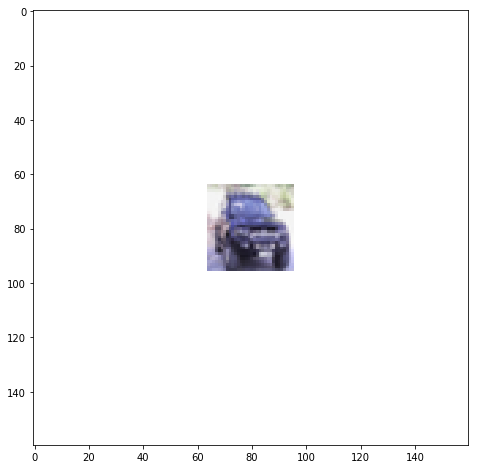

In [13]:
img = Image.open(image)
# change color channel from 4 to 3 for model
img = img.convert("RGB")

print("Test data shape:", np.array(img).shape)
print("Picture size:", img.size)
print("Color channel:", img.mode)
plt.figure(figsize = (8, 8))
plt.imshow(img)
plt.show()

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


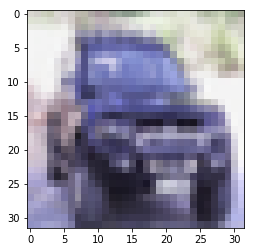

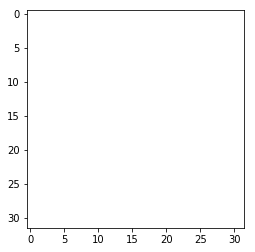

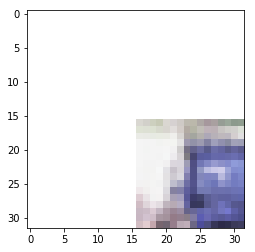

In [63]:
img_ar = np.array(img)

# extract middle part from the image
middle = img_ar[64:96, 64:96, :]
# extract top left part from the image
topleft = img_ar[:32, :32, :]
# extract middle a bit slided
mix = img_ar[48:80, 48:80, :]

print(middle.shape)
print(topleft.shape)
print(mix.shape)

plt.imshow(middle)
plt.show()
plt.imshow(topleft)
plt.show()
plt.imshow(mix)
plt.show()

## Model

In [32]:
loaded_model = load_model(model_path)
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3686912   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total para

## Preprocessing

In [60]:
middle_proc = middle.reshape((1, input_size, input_size, channel))
print(middle_proc.shape)

(1, 32, 32, 3)


In [61]:
middle_proc = middle_proc.astype("float32")
middle_proc /= 255

In [64]:
# do the same for other images
topleft_proc = topleft.reshape((1, input_size, input_size, channel))
topleft_proc = topleft_proc.astype("float32")
topleft_proc /= 255

mix_proc = mix.reshape((1, input_size, input_size, channel))
mix_proc = mix_proc.astype("float32")
mix_proc /= 255

## Prediction

In [62]:
pred_middle = loaded_model.predict(middle_proc)
df = pd.DataFrame({'label':label_name, 'prediction':np.round(pred_middle, decimals = 3).reshape((-1))})
df

,label,prediction
0,airplane,0.003
1,automobile,0.378
2,bird,0.000
3,cat,0.001
4,deer,0.001
5,dog,0.000
6,frog,0.001
7,horse,0.000
8,ship,0.030
9,truck,0.023


In [68]:
pred_topleft = loaded_model.predict(topleft_proc)
df = pd.DataFrame({'label':label_name, 'prediction':np.round(pred_topleft, decimals = 3).reshape((-1))})
df

,label,prediction
0,airplane,0.097
1,automobile,0.000
2,bird,0.014
3,cat,0.038
4,deer,0.001
5,dog,0.008
6,frog,0.001
7,horse,0.000
8,ship,0.009
9,truck,0.000


In [69]:
pred_mix = loaded_model.predict(mix_proc)
df = pd.DataFrame({'label':label_name, 'prediction':np.round(pred_mix, decimals = 3).reshape((-1))})
df

,label,prediction
0,airplane,0.067
1,automobile,0.000
2,bird,0.008
3,cat,0.033
4,deer,0.002
5,dog,0.017
6,frog,0.001
7,horse,0.000
8,ship,0.041
9,truck,0.000


## Sliding windows

In [74]:
# preprocessing
print(img_ar.shape)
img_proc = img_ar.reshape((-1, test_size, test_size, channel))
print(img_proc.shape)
img_proc = img_proc.astype("float32")
img_proc /= 255

(160, 160, 3)
(1, 160, 160, 3)


In [77]:
tmp = img_proc[:, :32, :32, :]
pred_tmp = loaded_model.predict(tmp)
df = pd.DataFrame({'label':label_name, 'prediction':np.round(pred_tmp, decimals = 3).reshape((-1))})
df

,label,prediction
0,airplane,0.097
1,automobile,0.000
2,bird,0.014
3,cat,0.038
4,deer,0.001
5,dog,0.008
6,frog,0.001
7,horse,0.000
8,ship,0.009
9,truck,0.000


In [81]:
tmp = img_proc[:, :32, :32, :]
pred_tmp = loaded_model.predict(tmp)
idx_max = np.argmax(pred_tmp)
print(idx_max)

0


Out test case has 160 pixel widths. Our model has 32 pixel input widths. 160 - 32 = 128. Suppose we silde 1 pixel by 1 pixel. So we can make 128 + 1 predictions when we slide horizontally. The vertical direction is the same, so we can make (128 + 1) * (128 + 1) = 16,641 predictions in total.

In [86]:
counter = 0
tmp = img_proc[:, :(input_size+counter), :(input_size+counter), :]
pred_tmp = loaded_model.predict(tmp)
idx_max = np.argmax(pred_tmp)
print(idx_max)

counter += 1
print(counter)

tmp = img_proc[:, counter:(input_size+counter), counter:(input_size+counter), :]
pred_tmp = loaded_model.predict(tmp)
idx_max = np.argmax(pred_tmp)
print(idx_max)

0
1
0


In [93]:
for i in range(129):
    # fix vertical
    tmp = img_proc[:, 64:96, i:(input_size+i), :]
    pred_tmp = loaded_model.predict(tmp)
    idx_max = np.argmax(pred_tmp)
    print(idx_max)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
3
3
5
5
5
5
5
5
0
4
2
2
2
2
2
0
8
8
8
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
3
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [95]:
for i in range(129):
    tmp = img_proc[:, 64:96, i:(input_size+i), :]
    pred_tmp = loaded_model.predict(tmp)
    idx_max = np.argmax(pred_tmp)
    prob_max = np.max(pred_tmp)
    print(np.round(prob_max, decimals = 2))

0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.08
0.05
0.05
0.05
0.06
0.07
0.06
0.06
0.08
0.1
0.08
0.06
0.09
0.09
0.09
0.06
0.04
0.04
0.05
0.07
0.05
0.07
0.05
0.06
0.06
0.06
0.08
0.12
0.1
0.22
0.24
0.38
0.36
0.28
0.09
0.04
0.05
0.06
0.1
0.12
0.17
0.15
0.13
0.12
0.14
0.15
0.14
0.11
0.08
0.08
0.11
0.14
0.17
0.18
0.17
0.17
0.15
0.14
0.1
0.08
0.06
0.07
0.09
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


In [96]:
idx_matrix = np.zeros(129)
prob_matrix = np.zeros(129)
for i in range(129):
    tmp = img_proc[:, 64:96, i:(input_size+i), :]
    pred_tmp = loaded_model.predict(tmp)
    idx_max = np.argmax(pred_tmp)
    prob_max = np.max(pred_tmp)
    
    # store values
    idx_matrix[i] = idx_max
    prob_matrix[i] = prob_max

In [98]:
# predict all over the place
idx_matrix = np.zeros((129, 129))
prob_matrix = np.zeros((129, 129))

for j in range(129):

    for i in range(129):
        tmp = img_proc[:, j:(input_size+j), i:(input_size+i), :]
        pred_tmp = loaded_model.predict(tmp)
        idx_max = np.argmax(pred_tmp)
        prob_max = np.max(pred_tmp)

        # store values
        idx_matrix[j, i] = idx_max
        prob_matrix[j, i] = prob_max

Taking too much time, around 1 min

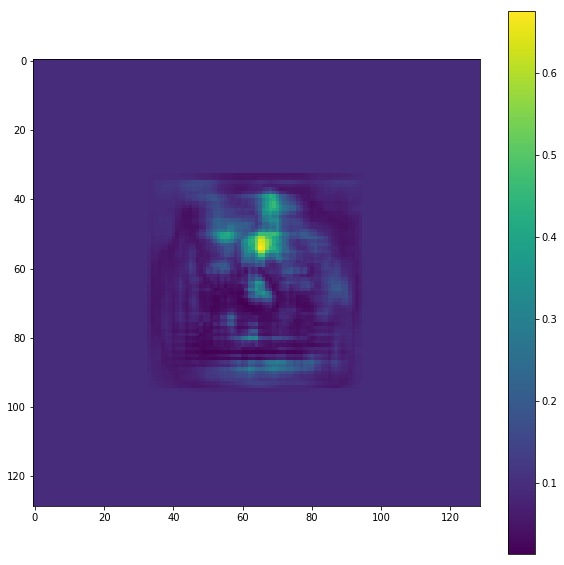

In [114]:
plt.figure(figsize = (10, 10))
plt.imshow(prob_matrix)
plt.colorbar()
plt.show()

In [228]:
# plt.figure(figsize = (20, 20))
# plt.imshow(prob_matrix)
# plt.colorbar()

# level = 0.5

# for i in range(129):
    
#     for j in range(129):
        
#         digit = idx_matrix[i, j]
        
#         plt.annotate(str(digit),
#                     xy = (j, i),
#                     horizontalalignment = 'center',
#                     verticalalignment = 'center',
#                     size = 5,
#                     color = 'white' if prob_matrix[i, j] < level else 'black')
        
# plt.show()

## Bounding boxes

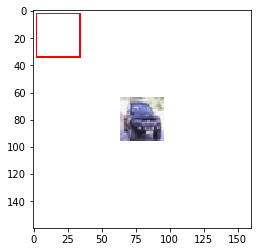

In [126]:
# example
tmp = cv2.rectangle(img = np.array(img), pt1 = (2, 2), pt2 = (34, 34), color = (255, 0, 0), thickness = 1)
plt.imshow(tmp)
plt.show()

So if you have appropriate pt1 and pt2 coordinate information, you can draw an appropriate bounding box.

In [128]:
print(prob_matrix.shape)
print(np.array(img).shape)

(129, 129)
(160, 160, 3)


In [134]:
prob_array = prob_matrix.flatten(order = "C")

In [220]:
length = len(prob_array)

location = []

for i in range(129):
    
    for j in range(129):
        
        tmp = [i, j, (input_size + i), (input_size + j)]
        location.append(tmp)

## Object detection

In [221]:
sum(prob_array > cutoff)

7

In [227]:
confident_location = np.array(location)[prob_array > cutoff]
confident_location

array([[52, 65, 84, 97],
       [52, 66, 84, 98],
       [53, 65, 85, 97],
       [53, 66, 85, 98],
       [54, 65, 86, 97],
       [54, 66, 86, 98],
       [55, 66, 87, 98]])

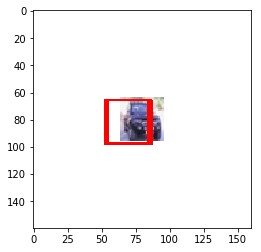

In [232]:
tmp = np.array(img)

for pt1_1, pt1_2, pt2_1, pt2_2 in confident_location:
    tmp = cv2.rectangle(img = tmp, pt1 = (pt1_1, pt1_2), pt2 = (pt2_1, pt2_2), color = (255, 0, 0), thickness = 1)
    
plt.imshow(tmp)
plt.show()